In [ ]:
import numpy as np
import pandas as pd

sps = pd.read_csv("../data/Shakespeare_data.csv")
print(sps.head(5))

The shakespeare data is loaded into a data frame and, but still needs to be cleaned. We want to remove all of the extraneous, non-dialogue lines, which can be done by removing all lines where the row includes NaN. These occur during transitions primarily and are not relevant to our model. They happen infrequently enough otherwise that it will not skew the data. Additionally, we will shuffle the rows here.

In [129]:
cleaned = sps.dropna()
#shuffle the rows
cleaned = cleaned.reindex(np.random.permutation(cleaned.index))
cleaned.head(5)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
108464,108465,A Winters Tale,106.0,1.2.501,CAMILLO,"The fabric of his folly, whose foundation"
59724,59725,Measure for measure,42.0,3.1.129,CLAUDIO,"Ay, but to die, and go we know not where,"
29538,29539,Cymbeline,24.0,2.2.126,CLOTEN,"Which buys admittance, oft it doth, yea, and m..."
67609,67610,A Midsummer nights dream,33.0,2.1.238,HELENA,When cowardice pursues and valour flies.
18848,18849,Antony and Cleopatra,92.0,1.2.195,MARK ANTONY,Pompey the Great and all his dignities


Additional value could be derived from the data set by looking at who speaks the most lines in each play, as this could be a proxy for pay scale when actually doing a production of a Shakespeare play. For instance, we compare King Henry IV to Prince Henry below.

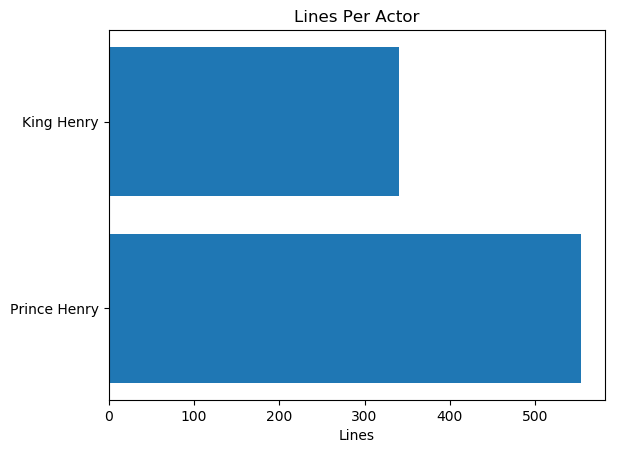

In [130]:
import matplotlib.pyplot as plt

plt.rcdefaults()
fig, ax = plt.subplots()

isHenryIV = cleaned['Play']=='Henry IV'
HenryIVPlay = cleaned[isHenryIV]
isKingHenry = HenryIVPlay['Player']=="KING HENRY IV"
kingHenryLines = len(HenryIVPlay[isKingHenry])
isPrinceHenry = HenryIVPlay['Player']=="PRINCE HENRY"
princeHenryLines = len(HenryIVPlay[isPrinceHenry])

nums = (kingHenryLines, princeHenryLines)
people = ('King Henry', 'Prince Henry')
y_pos = np.arange(len(people))
performance = 5 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

ax.barh(y_pos, nums, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()
ax.set_xlabel('Lines')
ax.set_title('Lines Per Actor')

plt.show()

The above shows just 2 of the players and the quantity of lines they have in Henry IV. This analysis could be extended to include any number of players. The specific feature engineering here is breaking down the dataset by play.

Next we will further prepare the dataset to be inputed to the classification model. We will use one-hot encoding to incorporate the strings into the model. One-hot encoding is used to ensure that the different feature attributes are not "mixed up" with one another. We also drop the player line here because it's not useful in one-hot encoding due to the wide variety of possibilities.

In [131]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
cat_columns = ["Play","Player"]
df_processed = pd.get_dummies(cleaned, prefix_sep="__", columns = cat_columns)

cat_dummies = [col for col in df_processed 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

processed_columns = list(df_processed.columns[:])

print(df_processed.head(5))
df_processed.drop(columns = ['PlayerLine'], inplace=True)
data = df_processed

        Dataline  PlayerLinenumber ActSceneLine  \
108464    108465             106.0      1.2.501   
59724      59725              42.0      3.1.129   
29538      29539              24.0      2.2.126   
67609      67610              33.0      2.1.238   
18848      18849              92.0      1.2.195   

                                               PlayerLine  \
108464          The fabric of his folly, whose foundation   
59724           Ay, but to die, and go we know not where,   
29538   Which buys admittance, oft it doth, yea, and m...   
67609            When cowardice pursues and valour flies.   
18848              Pompey the Great and all his dignities   

        Play__A Comedy of Errors  Play__A Midsummer nights dream  \
108464                         0                               0   
59724                          0                               0   
29538                          0                               0   
67609                          0                      

In [132]:
#Here we separate X and Y data.
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
Xtemp = data['PlayerLinenumber']
A = data.loc[:, ~data.columns.str.startswith('Player')]
X = pd.merge(Xtemp, A, left_index = True, right_index = True)
X = X.drop('ActSceneLine', axis = 1)
Y = data.loc[:, data.columns.str.startswith('Player')]
Y = Y.drop(['PlayerLinenumber'], axis = 1)

print("X: ")
print(X.head(5))
print("Y: ")
print(Y.head(5))


X: 
        PlayerLinenumber  Dataline  Play__A Comedy of Errors  \
108464             106.0    108465                         0   
59724               42.0     59725                         0   
29538               24.0     29539                         0   
67609               33.0     67610                         0   
18848               92.0     18849                         0   

        Play__A Midsummer nights dream  Play__A Winters Tale  \
108464                               0                     1   
59724                                0                     0   
29538                                0                     0   
67609                                1                     0   
18848                                0                     0   

        Play__Alls well that ends well  Play__Antony and Cleopatra  \
108464                               0                           0   
59724                                0                           0   
29538           

Next, we will use break the data sets into training and testing sets, then train a decision tree.

In [133]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size = .2)

print("X_test: ")
print(X_test.head())

print("Y_test: ")
print(Y_test.head())

model = tree.DecisionTreeClassifier()
model.fit(X_train, Y_train)

Y_predict = model.predict(X_test)

X_test: 
        PlayerLinenumber  Dataline  Play__A Comedy of Errors  \
108586              30.0    108587                         0   
96663               24.0     96664                         0   
110667             225.0    110668                         0   
75934               14.0     75935                         0   
92242               78.0     92243                         0   

        Play__A Midsummer nights dream  Play__A Winters Tale  \
108586                               0                     1   
96663                                0                     0   
110667                               0                     1   
75934                                0                     0   
92242                                0                     0   

        Play__Alls well that ends well  Play__Antony and Cleopatra  \
108586                               0                           0   
96663                                0                           0   
110667     

In [134]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, Y_predict)
print(accuracy)

0.7933526698682897


As you can see directly above, the accuracy of our model was roughly 79%. This is strong performance. One possible explanation is pure overfitting. Another explanation is that the input columns have a pretty much one to one correlation with the player, specifically the PlayerLinenumber being used. Since this is the case, it's no surprise that there's decent accuracy, though it may miss edge cases such as one-liners and the first and last line of the a player's consecutive dialogue.